In [1]:
import numpy as np
import pandas as pd

from h3 import h3

import folium
from folium import plugins

from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt

import os
import time
from selenium import webdriver

import cv2

import pickle

In [120]:
# fname = 'data_hackathon_v04.csv'
fname = 'new_csv.csv'
df = pd.read_csv(fname, sep=',', index_col="ride_id", parse_dates=["created_at"])


In [ ]:
df_used = pd.read_csv("used_cells.csv", sep=',', index_col="cell_id")
used_cell_ids = set(df_used.index.values)

In [121]:
locations_geo = df[["pickup_lat","pickup_lng"]].values

In [122]:
locations_grid = [h3.geo_to_h3(*loc, 7) for loc in locations_geo]
hex_set = set(locations_grid)
# hex_set = used_cell_ids

In [123]:
print(len(hex_set))

43


In [9]:
df["cell_id"] = df[["pickup_lat","pickup_lng"]].apply(lambda x: h3.geo_to_h3(*x, 7), axis=1)

In [10]:
df = df[df.cell_id.isin(hex_set)]

In [ ]:
df.to_csv("with_cell_id.csv")

In [124]:
def limitTimeRange(df, start, end):
    sdf = df[(df.created_at >= start) & (df.created_at < end)]

    cell_visits_gbc = sdf.groupby("cell_id").count()
    cell_visits = dict(zip(cell_visits_gbc.index.values, cell_visits_gbc["created_at"].values))
#     print(len(cell_visits))

    return cell_visits, sdf

In [12]:
def convert_to_hex(rgba_color) :
    red = str(hex(rgba_color[0]))[2:].upper()
    green = str(hex(rgba_color[1]))[2:].upper()
    blue = str(hex(rgba_color[2]))[2:].upper()
    alpha = str(hex(rgba_color[3]))[2:].upper()

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'
    if alpha=='0':
        alpha='00'

    return '#'+ red + green + blue + "FF" # + alpha

In [131]:
def plotMapFor(cell_visits, vmax = 500):
    gmap = folium.Map(location=[49.839922, 24.028741], tiles='Stamen Toner', zoom_start=12)

    # hm = plugins.HeatMap(sdf[["pickup_lat","pickup_lng"]].values)
    # print(hm)
    # hm
    # gmap.add_child(hm)
    # cells_boundaries

    # gj = folium.GeoJson(
    #     data={
    #         'type': 'Polygon',
    #         'coordinates': cells_boundaries
    #     })

    # gj.add_child(folium.Popup('outline Popup on GeoJSON'))
    # gj.add_to(gmap)
    # gmap

    cvv = cell_visits.values()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax)

    for cell_id, n_visits in cell_visits.items():
        poly = h3.h3_to_geo_boundary(cell_id)
        pgon = folium.Polygon(poly,
                    tooltip=str(n_visits),
                    fill_color=convert_to_hex(cm.jet(norm(n_visits), bytes=True)),
                    fill=True, fill_opacity=0.7,
                    stroke=False)
        pgon.add_to(gmap)
    
    return gmap

In [132]:
# %%time
cell_visits, sdf = limitTimeRange(df, "2018-01-10", "2019-01-11")
plotMapFor(cell_visits,  vmax=20000)

In [133]:
def cellsVisitsHourly(df, date):
    day = pd.Timedelta(days=1)
    hour = pd.Timedelta(hours=1)

    cell_ids = [dict() for i in range(24)]
    for i in range(7):
        for j in range(24):
            cvv = df[(df.created_at >= date+day*i+hour*j) & (df.created_at < date+day*i+hour*(j+1))].\
                        groupby(["cell_id"]).created_at.count()
            for k, v in zip(cvv.index.values, cvv.values): #df.created_at.dt.hour
                if k in cell_ids[j]:
                    cell_ids[j][k] += v / 7
                else:
                    cell_ids[j][k] = v / 7

    return cell_ids

# cellsVisitsHourly(df, pd.to_datetime("2019-01-10"))

In [134]:
def renderMapToImage(m, salt = 0):
    delay=0.7
    fn='testmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)

    browser = webdriver.Chrome()
    browser.get(tmpurl)

    time.sleep(delay)
    
    imname = "map_{}.png".format(salt)
    browser.save_screenshot(imname)
    browser.quit()
    
    return cv2.imread(imname)

# img = renderMapToImage(plotMapFor(cell_visits))
# plt.imshow(img)

In [ ]:
week = pd.Timedelta(weeks=1)

# for i in range(4):
i = 0
visits_h = cellsVisitsHourly(df, pd.to_datetime("2018-12-01") + week*i)

for j in range(24):
    img = renderMapToImage(plotMapFor(visits_h[j], vmax=20), salt=("{}-{:02}".format(i, j)))

#     print(img)
#     plt.imshow(img)

In [ ]:
subsample = df[(df.created_at > "2019-01-03") & (df.created_at < "2019-01-04")][
    ["pickup_lat","pickup_lng","dropoff_lat","dropoff_lng"]].values[:10]


In [135]:
start_date = pd.to_datetime("2018-08-21")
hour = pd.Timedelta(hours=1)

dataset = []
n_zones = len(hex_set)
id_lookup = dict(zip(sorted(list(hex_set)), range(len(hex_set))))
for i in range(24*170):
    data_points = [0] * n_zones
    current_cell_visits, sdf = limitTimeRange(df, start_date, start_date + hour)
    start_date += hour
    for k, v in current_cell_visits.items():
        data_points[id_lookup[k]] += v
    
    dataset.append(data_points)

In [136]:
img = np.array(dataset)
with open("dataset.pickle", "wb") as f:
    pickle.dump(img, f)

cv2.imwrite("/tmp/kek.png", img)

True

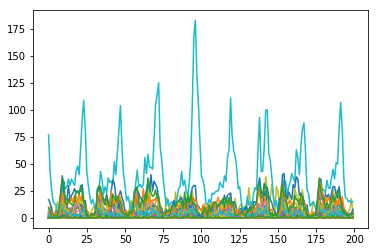

In [138]:
for i in range(len(hex_set)):
    plt.plot(img[:200, i], label=str(i))

In [139]:
tseries = img.transpose()

split_pos = tseries.shape[1] - 24*7
print(split_pos)

train_s = tseries[:, :split_pos]
test_s = tseries[:, split_pos:]

3912


In [164]:
from numpy import fft

def fourierExtrapolation(x, n_predict, bins = 2000):
    n = x.size
    n_harm = bins
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))

    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [141]:
def loss(xs, ys):
    return np.mean(np.square(np.log((xs + 1) / (ys + 1))))

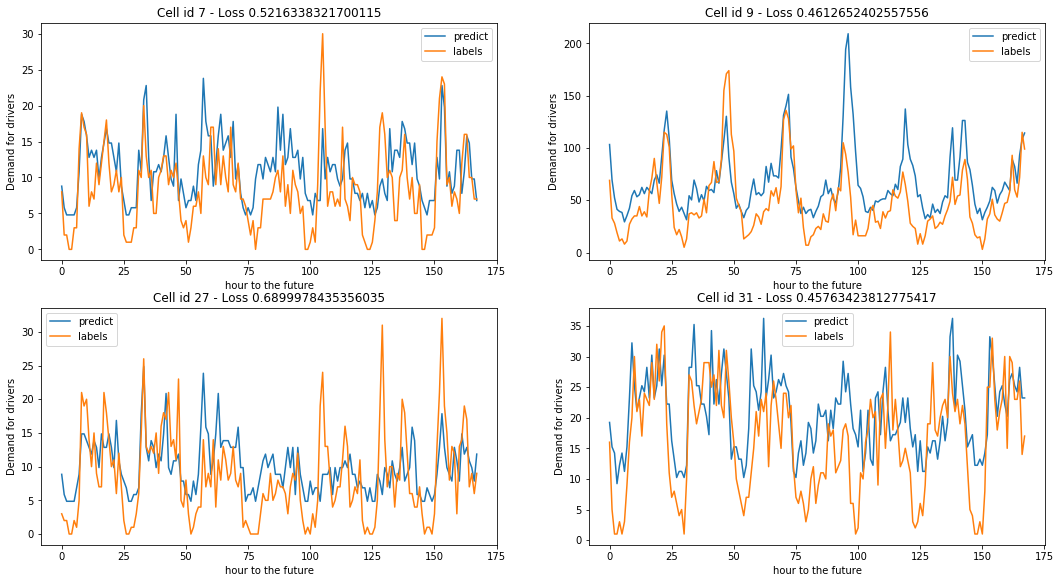

In [191]:

fig = plt.figure(figsize = (18, 1.2 * 8))

# for j,i in enumerate([3, 6, 7, 9, 15, 24, 27, 31]): #range(38):
for j,i in enumerate([7, 9, 27, 31]):
# for j,i in enumerate(range(42)):
    xs = train_s[i]
    exp_xs = fourierExtrapolation(xs, test_s.shape[1], 2000)
    pred_xs = exp_xs[split_pos:]

    err = loss(pred_xs, test_s[i])

    a = fig.add_subplot(2, 2, j + 1)
    plt.plot(pred_xs, label = "predict")
    plt.plot(test_s[i], label = "true")
    plt.xlabel("hour to the future")
    plt.ylabel("Demand for drivers")
    plt.legend(["predict", "labels"])
    a.set_title("Cell id {} - Loss {}".format(i, err))

In [189]:
errs = []

predictions = []
ground_truth = []

for i in range(len(hex_set)):
    xs = train_s[i]
    exp_xs = fourierExtrapolation(xs, test_s.shape[1])
    pred_xs = exp_xs[split_pos:]
    
    predictions.append(pred_xs)
#     ground_truth.append(exp_xs)

    errs.append(loss(pred_xs, test_s[i]))

print("Mean loss across the cells well-prediction: ", np.mean(errs))
predictions = np.array(predictions)
# ground_truth = np.array(ground_truth)

Mean loss across the cells well-prediction:  0.36379172518120406


In [ ]:
# predictions

# for (predictions)
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output.avi', fourcc, 1.0, (1280,720))
for i in range(24*4): #test_s.shape[1]):
    cell_visits = dict(zip(sorted(list(hex_set)), predictions[:,i]))
    img1 = renderMapToImage(plotMapFor(cell_visits,  vmax=20), salt=("{}-{:02}".format(0, i)))[:,300:1150]
    cell_visits = dict(zip(sorted(list(hex_set)), test_s[:,i]))
    img2 = renderMapToImage(plotMapFor(cell_visits,  vmax=20), salt=("{}-{:02}".format(1, i)))[:,300:1150]
    img = np.concatenate([img1,img2], axis=1)
    frame = cv2.resize(img,(1280,720))
    out.write(frame)
out.release()

In [175]:
errs_rg = []

# for bins in range(500, 2000, 100):
for bins in [700]:
    errs = []
    for i in range(len(hex_set)):
        xs = train_s[i]
        exp_xs = fourierExtrapolation(xs, 24, bins = bins)
        pred_xs = exp_xs[split_pos:]

        errs.append(loss(pred_xs, test_s[i][:24]))
    
    err = np.mean(errs)
    print("Mean loss across cells day-prediction: ", err)
    errs_rg.append(err)

Mean loss across the cells day-prediction:  0.3225037912716584
